# ResNet-GRU-400

In [1]:
import numpy as np
import pandas as pd
import random
import os as os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
sns.set_style("darkgrid")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
seed = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

# ResNet-GRU architecture

In [4]:
# CNN ###############################
class ResNet_block(nn.Module):    
    def __init__(self, filters, kernels):
        super().__init__()
        f1, f2, f3 = filters
        k1, k2, k3 = kernels
        self.conv1 = nn.Conv2d(1,f1, k1, 1)
        self.bn1 = nn.BatchNorm2d(f1)
        self.conv2 = nn.Conv2d(f1,f2, k2, 1)
        self.bn2 = nn.BatchNorm2d(f2)
        self.conv3 = nn.Conv2d(f2,f3, k3, 1)
        self.maxpool = nn.MaxPool2d(2,2)
        self.flat = nn.Flatten()
        self.relu = nn.ReLU()
        #this layer is to get the identity to have
        #the same shape as the other branch, bias = False
        self.fc0 = nn.Linear(320,256, bias = False)
        #convolution branch/main branch
        self.conv_total = nn.Sequential(
            self.conv1,
            self.maxpool,
            #self.bn1,
            self.relu,
            self.conv2,
            self.maxpool,
            #self.bn2,
            self.relu,
            self.conv3,
            self.flat
        )
        #shortcut branch
        self.shortcut = nn.Sequential(self.flat, self.fc0)

    def forward(self,x):
        #x_i and x must have the same shape
        x_i = self.shortcut(x)
        x = self.conv_total(x)
        xt = x+ x_i
        #xt = torch.cat([x, x_i], dim = 1) 
        return xt

In [5]:
class RNN_block(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(RNN_block,self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers        
        #self.lstm = nn.LSTM(input_size = self.D,
        #                   hidden_size = self.M,
        #                   num_layers = self.L,
        #                   batch_first = True)    
        self.gru = nn.GRU(input_size = self.D,
                           hidden_size = self.M,
                           num_layers = self.L,
                           batch_first = True,
                          bidirectional=False)
        #self.fc1 = nn.Linear(self.M, 128)
        #self.fc2 = nn.Linear(128, self.K)
    def forward(self, X):
        #input X is NxTxD
        #initial hidden state h
        #for bidirectional: Need to multiply L by 2
        #h0 = torch.zeros(self.L*2, X.size(0), self.M).to(device)
        #non-bidirectional
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        #output is NxTx2M for birdir, NxTxM for non-bidir
        out, _ = self.gru(X, h0)   
        #we only want h(T) at the final time step
        # output is now of shape (N, M)
        out = out[:, -1, :]
        return out

In [6]:
class ResNet_RNN_hybrid(nn.Module):
    def __init__(self, resnet_block, rnn_block, feat_vec_size):
        super(ResNet_RNN_hybrid, self).__init__()
        self.resnet_block = resnet_block
        self.rnn_block = rnn_block
        self.feat_vec_size = feat_vec_size
        self.fc1 = nn.Linear(self.feat_vec_size, 1024)
        self.fc2 = nn.Linear(1024, 4)
        
    def forward(self, x):
        #output of cnn block is (N,848)
        x1 = x.view(-1,1, 16,20)
        x1 = self.resnet_block(x1)
        #output of rnn block is (N,M )
        x2 = self.rnn_block(x)
        #concatenate the 2 outputs to produce a feat vec (N, M+208)
        xx = torch.cat([x1, x2], dim = 1)
        # pass through linear layers
        xx = self.fc1(xx)
        #final output is 4
        xx = self.fc2(xx)      
        return xx

In [7]:
resnet_block = ResNet_block([128,64,128], [4,3,2])
resnet_block.to(device)

#gru_block = RNN_block(20, 256, 2, 4)
gru_block = RNN_block(20, 400, 2, 4)
gru_block.to(device)

model = ResNet_RNN_hybrid(resnet_block, gru_block, 400+256)
model.to(device)

ResNet_RNN_hybrid(
  (resnet_block): ResNet_block(
    (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flat): Flatten(start_dim=1, end_dim=-1)
    (relu): ReLU()
    (fc0): Linear(in_features=320, out_features=256, bias=False)
    (conv_total): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ReLU()
      (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Re

In [8]:
#count the number of parameters in the model
params = [p.numel() for p in model.parameters() if p.requires_grad]
print(sum(params))

2336836


# Load data, define dataset and dataloaders

In [9]:
X_train = np.load('/kaggle/input/cicy4-data-processing/conf_Xtrain.npy')
X_test = np.load('/kaggle/input/cicy4-data-processing/conf_Xtest.npy')
X_valid = np.load('/kaggle/input/cicy4-data-processing/conf_Xvalid.npy')

y_train = np.load('/kaggle/input/cicy4-data-processing/hodge_ytrain.npy')
y_test= np.load('/kaggle/input/cicy4-data-processing/hodge_ytest.npy')
y_valid = np.load('/kaggle/input/cicy4-data-processing/hodge_yvalid.npy')

print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(652092, 16, 20) (72455, 16, 20) (181137, 16, 20)
(652092, 4) (72455, 4) (181137, 4)


In [10]:
#Convert data to torch tensor with float32 precision 
#(needed to be compatible with the floating decision of the network parameters)
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))

X_valid = torch.from_numpy(X_valid.astype(np.float32)) 
y_valid = torch.from_numpy(y_valid.astype(np.float32)) 

X_test = torch.from_numpy(X_test.astype(np.float32)) 
y_test= torch.from_numpy(y_test.astype(np.float32))

In [11]:
class CICY4Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y        
    def __len__(self):
        return len(self.X)      
    def __getitem__(self, idx):
        X0 = self.X[idx]
        y0 = self.y[idx]  
        return X0, y0
        
train_set = CICY4Dataset(X_train, y_train)
val_set = CICY4Dataset(X_valid, y_valid)
test_set = CICY4Dataset(X_test, y_test)

In [12]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

In [13]:
print(f'Train loader contains {len(train_loader)} batches, each of size 128')
print(f'Valid loader contains {len(val_loader)} batches, each of size 128')
print(f'Test loader contains {len(test_loader)} batches, each of size 128')
#d, t = next(iter(train_loader))
#print(d.dtype)
#print('Each data and target batch have the following shape')
#print(d.shape, t.shape)

for d, t in test_loader:
    print(d.dtype)
    print('Each data and target batch have the following shape')
    print(d.shape, t.shape)
    break

Train loader contains 5095 batches, each of size 128
Valid loader contains 567 batches, each of size 128
Test loader contains 1416 batches, each of size 128
torch.float32
Each data and target batch have the following shape
torch.Size([128, 16, 20]) torch.Size([128, 4])


# Shape tracing

In [14]:
 X = X_train[0].to(device)
print('CNN BLOCK SHAPE TRACING')
print(f'Original shape of the image before passing through the network: \n {X.shape}\n')

print('Reshape the size to take in account the batch number')
X = X.view(1,1,16,20)
print(f'The new size is {X.shape}\n')
#shortcut branch
X_i = resnet_block.shortcut(X)
print(f'Shape of the image after passing through the shortcut: \n {X_i.shape}\n')
#main branch
X = resnet_block.conv_total(X)
print(f'Shape of the image after passing through {resnet_block.conv_total}: \n {X.shape}\n')

X = resnet_block.flat(X)
print(f'After flattening {X.shape}')
# adding 2 branches
Xt = X+X_i
print(f'After adding 2 branches: {Xt.shape}')


CNN BLOCK SHAPE TRACING
Original shape of the image before passing through the network: 
 torch.Size([16, 20])

Reshape the size to take in account the batch number
The new size is torch.Size([1, 1, 16, 20])

Shape of the image after passing through the shortcut: 
 torch.Size([1, 256])

Shape of the image after passing through Sequential(
  (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): ReLU()
  (6): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (7): Flatten(start_dim=1, end_dim=-1)
): 
 torch.Size([1, 256])

After flattening torch.Size([1, 256])
After adding 2 branches: torch.Size([1, 256])


In [15]:
 X = X_train[0].to(device)

print('RNN BLOCK SHAPE TRACING')
print(f'Original shape of the image before passing through the network: \n {X.shape}\n')

print('Reshape the size to take in account the batch number')
X = X.view(1,16,20)
print(f'The new size is {X.shape}\n')

#h0 = torch.zeros(gru_block.L*2, X.size(0), gru_block.M).to(device)
h0 = torch.zeros(gru_block.L, X.size(0), gru_block.M).to(device)
X, _ = gru_block.gru(X, h0)
print(f'Shape of the image after passing through the {gru_block.gru}: \n {X.shape}\n')

#get only the h(T) at the last time step
Xg = X[:, -1, :]
print(f'The final output shape is {Xg.shape}')
#print(X)
#print(f'Target: {y}')

RNN BLOCK SHAPE TRACING
Original shape of the image before passing through the network: 
 torch.Size([16, 20])

Reshape the size to take in account the batch number
The new size is torch.Size([1, 16, 20])

Shape of the image after passing through the GRU(20, 400, num_layers=2, batch_first=True): 
 torch.Size([1, 16, 400])

The final output shape is torch.Size([1, 400])


In [16]:
X = X_train[0].to(device)
print('ResNet-RNN HYBRID BLOCK SHAPE TRACING\n')
#print(f'Original shape of the image before passing through the network: \n {X.shape}\n')

#print('Reshape the size to take in account the batch number')
X = X.view(1,16,20)
#print(f'The new size is {X.shape}\n')
X1 = model.resnet_block(X.view(1,1,16,20))
print(f'After Resnet block {X1.shape}\n')

X2= model.rnn_block(X)
print(f'After GRU block {X2.shape}\n')

X = model(X)
print(f'Shape  after passing through the entire network: \n {X.shape}\n')

ResNet-RNN HYBRID BLOCK SHAPE TRACING

After Resnet block torch.Size([1, 256])

After GRU block torch.Size([1, 400])

Shape  after passing through the entire network: 
 torch.Size([1, 4])



# Utility functions for training

In [17]:
def train_one_epoch(model, criterion, optimizer, train_loader, cnn = False):
    model.train()
    train_loss = []
    for inputs, target in train_loader:
        if cnn:
            inputs = inputs.view(batch_size,1,16,20)
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()
        out = model(inputs)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    #average the train_loss list in for all batches in the train_gen
    train_loss = np.mean(train_loss)    
    return train_loss

In [18]:
def validate_one_epoch(model, criterion, optimizer, val_loader, cnn = False):
    model.eval()
    test_loss = []
    for inputs, target in val_loader:
        if cnn:
            inputs = inputs.view(batch_size,1,16,20)
        inputs, target = inputs.to(device), target.to(device)
        out = model(inputs)
        loss = criterion(out, target)
        test_loss.append(loss.item())
    #average the test_loss list in for all batches in the test_gen
    test_loss = np.mean(test_loss)
    return test_loss

In [19]:
def batch_gd_scheduler(model, new_model_name, criterion, optimizer, train_loader, val_loader, scheduler,
                         epochs, device, batch_size=128,  cnn = False):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    patience = 0
    best_loss = 1000
    max_patience = 20
    for i in range(epochs):
        t0 = datetime.now()
        train_loss = train_one_epoch(model, criterion, optimizer,train_loader)
        test_loss = validate_one_epoch(model, criterion, optimizer,val_loader)
        #Early stopping based on test loss
        if i == 0:
            best_loss = test_loss   
            torch.save(model, f'/kaggle/working/{new_model_name}.pt')
            print(f'Model saved as {new_model_name} at epoch {i}')
        else:
            if test_loss < best_loss:
                best_loss = test_loss
                torch.save(model, f'/kaggle/working/{new_model_name}.pt')
                print(f'Model overwritten at epoch {i}, new best val loss {best_loss: .4f}')
                patience = 0
            else:
                patience = patience +1
                #print(f'No improvement, current patience level is {patience} at epoch {i}')
        if patience > max_patience:
            print(f'Max patience reached, training is terminated at epoch {i}')
            break
        #if early_stopper.early_stop(test_loss):             
        #    break
        #Apply scheduler after the train+validate parts
        before_lr = optimizer.param_groups[0]["lr"]
        scheduler.step(test_loss)
        after_lr = optimizer.param_groups[0]["lr"]
        train_losses[i] = train_loss
        test_losses[i] = test_loss
        #write the losses into a csv file
        loss_dict = {'train_loss': train_losses, 'test_loss': test_losses}
        dd = pd.DataFrame(loss_dict)
        dd.to_csv('loss_dict_resnet_gru_400.csv', index = False)
        dt = datetime.now()-t0
        if i%10==0:
            print(f'Epoch: {i}/{epochs}, train loss: {train_loss: .3f}, val_loss: {test_loss: .3f}, duration: {dt}, learning rate: {before_lr, after_lr}')
    return train_losses, test_losses

In [20]:
def train_from_scratch_or_load(load_model_weight,new_model_name, epochs, cnn = False):    
    if load_model_weight==None:
        #criterion = nn.MSELoss()
        criterion = nn.HuberLoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, min_lr = 1e-7)
        train_losses, test_losses=batch_gd_scheduler(model, new_model_name, criterion, 
                                                     optimizer,train_loader, val_loader,
                                                      scheduler, epochs, 
                                                       device = device, cnn=cnn)
        return train_losses, test_losses
    else:
        if torch.cuda.is_available():
            trained_model = torch.load(load_model_weight)     
        else:
            trained_model = torch.load(load_model_weight, map_location=torch.device('cpu'))       
        return trained_model

In [21]:
def load_and_retrain(load_model_weight, new_model_name, epochs, cnn=False):
    trained_model = torch.load(load_model_weight) 
    #criterion = nn.MSELoss()
    criterion = nn.HuberLoss()
    optimizer = torch.optim.AdamW(trained_model.parameters(),lr=0.0001)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, min_lr = 5e-7)
    trained_model.train()
    train_losses, test_losses=batch_gd_scheduler(trained_model,new_model_name, criterion, optimizer,
                                                 train_loader, val_loader, 
                                                 scheduler, epochs, 
                                                 device = device, cnn=cnn)
    return trained_model, train_losses, test_losses



In [22]:
def plot_losses(train_losses, test_losses):
    # Plot the train loss and test loss per iteration
    plt.plot(train_losses, label='train loss')
    plt.plot(test_losses, label='val loss')
    plt.legend()
    plt.show()

In [23]:
def get_pred_n_acc(models, device, dataloader, num_iter):
    i = 0
    ypreds =[]
    targets = []
    #The last batch might not have size 128
    while i< num_iter:
        for data, target in dataloader:
            #this empty list is to hold all models' preds
            ypred = []    
            data= data.to(device)
            data = data.to(torch.float32)
            target = target.to(torch.float32)
            #append the 'i^th' target
            targets.append(target)
            for model in models:
                model.eval()
                yp = model(data)
                yp = yp.detach().cpu().numpy()
                ypred.append(yp)
            #take the mean of all models' predictions
            ypred = np.array(ypred).mean(axis = 0)
            ypred = np.round(ypred)
            i+=1
            #append ypred, targets inside the 'i' loop
            # append the 'i^th' mean prediction
            ypreds.append(ypred)   
            if i == num_iter:
                break 
     #Do not convert ypreds, targets to np.array at this point,
    #since the last batch has a different size, causing an error !
    #CALCULATING ACCURACY    
    yp =  np.concatenate([ypreds[j] for j in range(len(ypreds))], axis = 0)
    tgs =  np.concatenate([targets[j] for j in range(len(targets))], axis = 0)
    h11_acc = ((yp[:,0] == tgs[:,0]).sum())/len(yp)
    h21_acc = ((yp[:,1] == tgs[:,1]).sum())/len(yp)
    h31_acc = ((yp[:,2] == tgs[:,2]).sum())/len(yp)
    h22_acc = ((yp[:,3] == tgs[:,3]).sum())/len(yp)
    acc = [h11_acc*100,h21_acc*100,h31_acc*100,h22_acc*100 ]
    return  yp, tgs, acc

# Train loop

In [24]:
load_model_weight = None
epochs = 550
new_model_name = 'ResNet-GRU-400'
train_losses, test_losses=train_from_scratch_or_load(load_model_weight,new_model_name,  epochs, cnn = False)

Model saved as ResNet-GRU-400 at epoch 0
Epoch: 0/550, train loss:  7.919, val_loss:  7.456, duration: 0:00:54.326498, learning rate: (0.01, 0.01)
Model overwritten at epoch 1, new best val loss  7.4444
Model overwritten at epoch 4, new best val loss  7.4005
Model overwritten at epoch 6, new best val loss  7.3964
Model overwritten at epoch 10, new best val loss  7.3882
Epoch: 10/550, train loss:  7.607, val_loss:  7.388, duration: 0:00:53.741075, learning rate: (0.01, 0.01)
Model overwritten at epoch 14, new best val loss  7.3783
Epoch: 20/550, train loss:  7.668, val_loss:  7.687, duration: 0:00:53.872421, learning rate: (0.01, 0.01)
Model overwritten at epoch 24, new best val loss  7.3632
Epoch: 30/550, train loss:  7.687, val_loss:  7.436, duration: 0:00:53.913395, learning rate: (0.01, 0.01)
Model overwritten at epoch 36, new best val loss  7.2961
Model overwritten at epoch 37, new best val loss  7.2704
Model overwritten at epoch 38, new best val loss  7.2487
Model overwritten at e

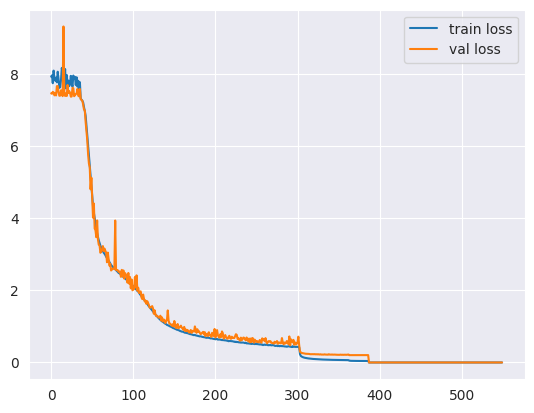

In [25]:
plot_losses(train_losses, test_losses)

# Train/validation/test accuracy

In [26]:
#Train accuracy
yt, tgt, acct = get_pred_n_acc([model], device, train_loader, num_iter = len(train_loader))
#validation accuracy
yv, tgv, accv = get_pred_n_acc([model], device, val_loader, num_iter = len(val_loader))
print(f'Train data, target shapes: {yt.shape, tgt.shape},\n train accuracies {acct}')
print(f'Validation data, target shapes: {yv.shape, tgv.shape},\n validation accuracies {accv}')

Train data, target shapes: ((652092, 4), (652092, 4)),
 train accuracies [99.77457168620379, 96.12585340718795, 98.04858823601577, 81.26322666126865]
Validation data, target shapes: ((72455, 4), (72455, 4)),
 validation accuracies [99.1953626388793, 92.53329652887999, 86.87047132703057, 59.91995031398799]


In [27]:
#Inference: Test accuracy
yts, tgts, accts = get_pred_n_acc([model], device, test_loader, num_iter = len(test_loader))
print(f'Test data, target shapes: {yts.shape, tgts.shape},\n test accuracies {accts}')

Test data, target shapes: ((181137, 4), (181137, 4)),
 test accuracies [99.22931261972981, 92.49463113554933, 86.7117154419031, 59.60792107631241]
